## Simple Moving Average

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_excel('DATA FILE 334 (2).xlsx')
df.columns

Index([             'Part ID',    'Planning Leadtime',         'Order Policy',
                'Order Point',     'Safety Stock Qty',      'Fixed Order Qty',
             'Days Of Supply',    'Minimum Order Qty',    'Maximum Order Qty',
         'Multiple Order Qty',                  'Fab',                  'Pur',
                    'Stocked',          'Detail Only',              'Purc Lt',
                   'Abc Code',     'Inventory Locked',           'Inventory$',
         'Unit Material Cost',     'Annual Usage Qty',        'Prev Yr Usage',
             'Roll Ann Usage',          'Qty On Hand',    'Qty Available Mrp',
                   'TotAlloc',           'Coeff_Code',             'Stock Um',
           'Def Orig Country',       'Primary Whs Id',       'Primary Loc Id',
         'Annual Usage Value',       2666342.46838269,             'Profit %',
       'Cummulatove Profit %',           'Jan (2018)',           'Feb (2018)',
                 'Mar (2018)',           'Apr (2018)

### Accuracy in Forecasting

In [6]:
# all
start_index, end_index = 34, 58

Using historical data (2018) to build the model and then test its accuracy on future data (2019).

In [7]:
# Identify the indices for columns corresponding to 2018 and 2019
start_index_2018 = df.columns.get_loc("Jan (2018)")
end_index_2018 = df.columns.get_loc("Dec (2018)")
start_index_2019 = df.columns.get_loc("Jan (2019)")
end_index_2019 = df.columns.get_loc("Dec (2019)")

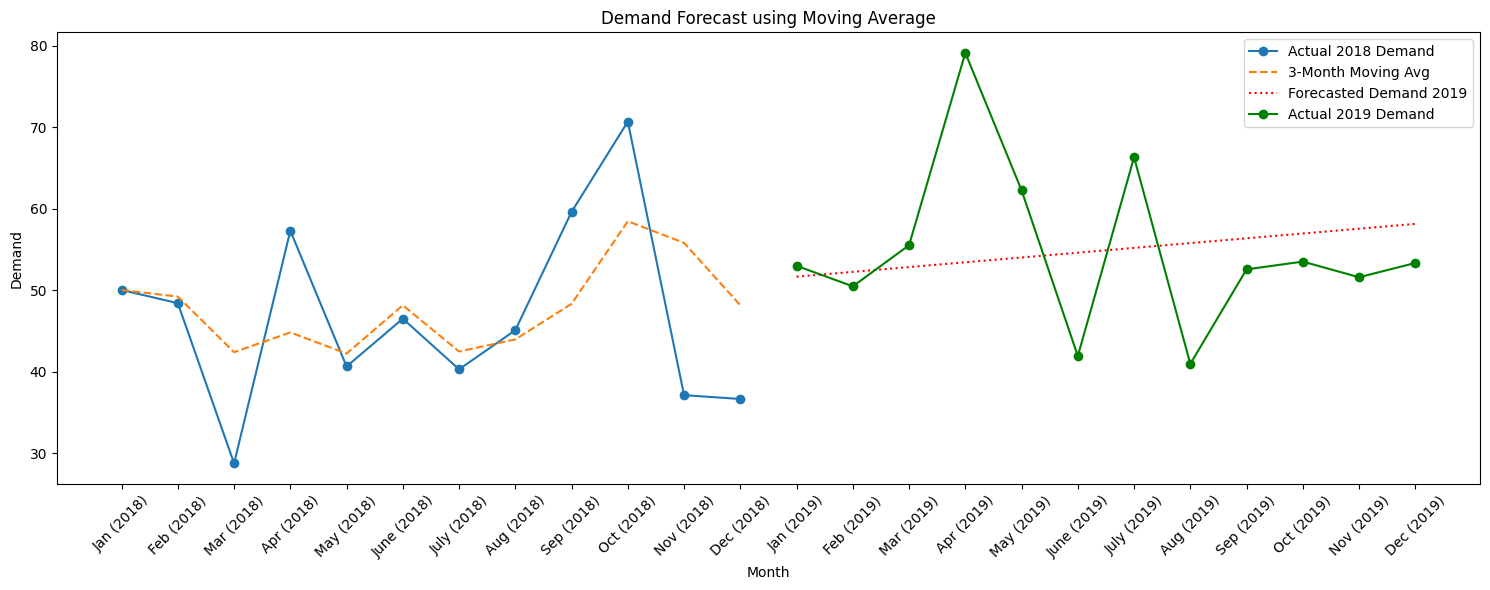

In [8]:
from sklearn.linear_model import LinearRegression

window_size = 3

# Calculate the moving average on the training data (2018)
train_data = df.iloc[:, start_index_2018:end_index_2018+1].mean(axis=0)
train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean().dropna()

# Fit a linear model to the moving averages
time_index = np.arange(len(train_moving_avg)).reshape(-1, 1)
model = LinearRegression().fit(time_index, train_moving_avg)

# Forecast moving averages for 2019 using the linear model
forecast_length = end_index_2019 - start_index_2019 + 1
forecast_time_index = np.arange(len(train_moving_avg), len(train_moving_avg) + forecast_length).reshape(-1, 1)
forecast_moving_avg = model.predict(forecast_time_index)

# Prepare the forecast series
test_forecast = pd.Series(forecast_moving_avg.flatten(), index=df.columns[start_index_2019:end_index_2019+1])

# Assuming 'test_data' contains the actual demand for 2019
test_data = df.iloc[:, start_index_2019:end_index_2019+1].mean(axis=0)

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.columns[start_index_2018:end_index_2018+1], train_data, label='Actual 2018 Demand', marker='o')
plt.plot(df.columns[start_index_2018:end_index_2018+1], train_moving_avg, label='3-Month Moving Avg', linestyle='--')
plt.plot(test_forecast.index, test_forecast, label='Forecasted Demand 2019', color='red', linestyle=':')
plt.plot(df.columns[start_index_2019:end_index_2019+1], test_data, label='Actual 2019 Demand', marker='o', color='green', zorder=5)

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Demand Forecast using Moving Average')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error

# Forecast Error (Actual - Predicted)
forecast_errors = test_data - test_forecast

# Mean Absolute Deviation (MAD)
mad = forecast_errors.abs().mean()

# Mean Squared Error (MSE)
mse = mean_squared_error(test_data, test_forecast)

# Mean Absolute Percentage Error (MAPE)
mape = (forecast_errors.abs() / test_data).mean() * 100

print(f"Forecasted Values: {forecast_errors}")
print(f"MAD: {mad}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")

Forecasted Values: Jan (2019)      1.332157
Feb (2019)     -1.774974
Mar (2019)      2.684623
Apr (2019)     25.698534
May (2019)      8.244697
June (2019)   -12.677557
July (2019)    11.118338
Aug (2019)    -14.818826
Sep (2019)     -3.813194
Oct (2019)     -3.447312
Nov (2019)     -5.954763
Dec (2019)     -4.793402
dtype: float64
MAD: 8.029864818484262
MSE: 110.7764912487142
MAPE: 14.495810617044134


### On a Product Level

#### Repeaters (First 10 Products)

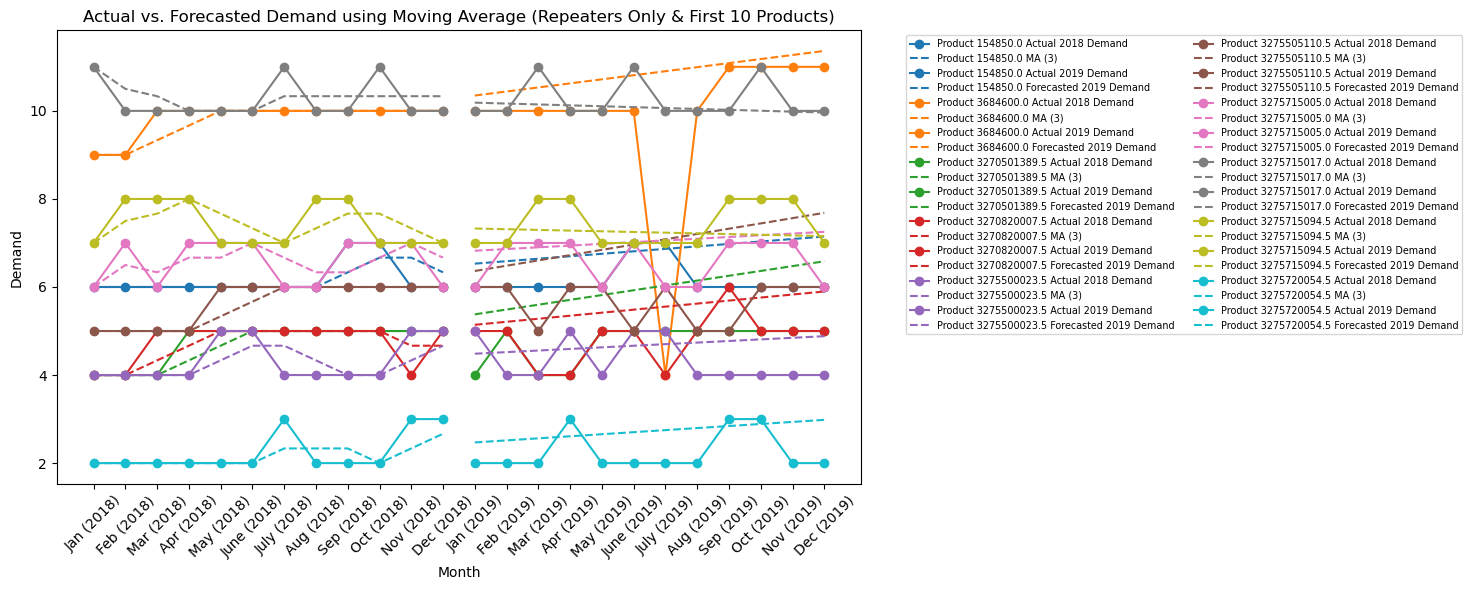

Average MAD for first 10 products: 0.7535871535871534
Average MSE for first 10 products: 1.129411367953034
Average MAPE for first 10 products: 15.87145391785543


In [166]:
from sklearn.linear_model import LinearRegression

# Filter for 'Repeater' products
df_repeaters = df[df['Coeff_Code'] == 'Repeater'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_repeaters.columns.get_loc("Jan (2018)")
end_index_2018 = df_repeaters.columns.get_loc("Dec (2018)")
start_index_2019 = df_repeaters.columns.get_loc("Jan (2019)")
end_index_2019 = df_repeaters.columns.get_loc("Dec (2019)")

# Initialize a plot
plt.figure(figsize=(15, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10)) 

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_repeaters.iterrows():
    if num_products_processed < 10:

        # Get the color for the current product
        color = colors[num_products_processed]

        # Calculate the moving average for 2018
        train_data = row.iloc[start_index_2018:end_index_2018+1]
        train_data = train_data.dropna()
        test_data = row.iloc[start_index_2019:end_index_2019+1].dropna()
        
        train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean().dropna()
        
        # Fit a linear model to the moving averages
        time_index = np.arange(len(train_moving_avg)).reshape(-1, 1)
        model = LinearRegression().fit(time_index, train_moving_avg)
        
        # Forecast moving averages for 2019
        forecast_time_index = np.arange(len(train_moving_avg), len(train_moving_avg) + len(test_data)).reshape(-1, 1)
        forecast_moving_avg = model.predict(forecast_time_index)
        
        # Plot training data and moving average
        plt.plot(df_repeaters.columns[start_index_2018:end_index_2018+1], train_data, marker='o', color=color, label=f'Product {product_id} Actual 2018 Demand')
        plt.plot(df_repeaters.columns[start_index_2018:end_index_2018+1], train_moving_avg, linestyle='--', color=color, label=f'Product {product_id} MA (3)')
        
        # Plot forecast
        forecast_dates = df_repeaters.columns[start_index_2019:end_index_2019+1]
        plt.plot(forecast_dates, test_data, marker='o', color=color, label=f'Product {product_id} Actual 2019 Demand')
        plt.plot(forecast_dates, forecast_moving_avg, linestyle='--', color=color, label=f'Product {product_id} Forecasted 2019 Demand')

        # Calculate errors
        errors = test_data.values - forecast_moving_avg.flatten()
        
        # Calculate MAD, MSE, MAPE
        mad = np.mean(np.abs(errors))
        mse = np.mean(errors**2)
        mape = np.mean(np.abs(errors / test_data.values)) * 100
        
        # Store the calculated metrics
        mad_list.append(mad)
        mse_list.append(mse)
        mape_list.append(mape)
    
    # Increment the counter
    num_products_processed += 1

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand using Moving Average (Repeaters Only & First 10 Products)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first 10 products: {average_mad}')
print(f'Average MSE for first 10 products: {average_mse}')
print(f'Average MAPE for first 10 products: {average_mape}')

#### Runners (First 10 Products)

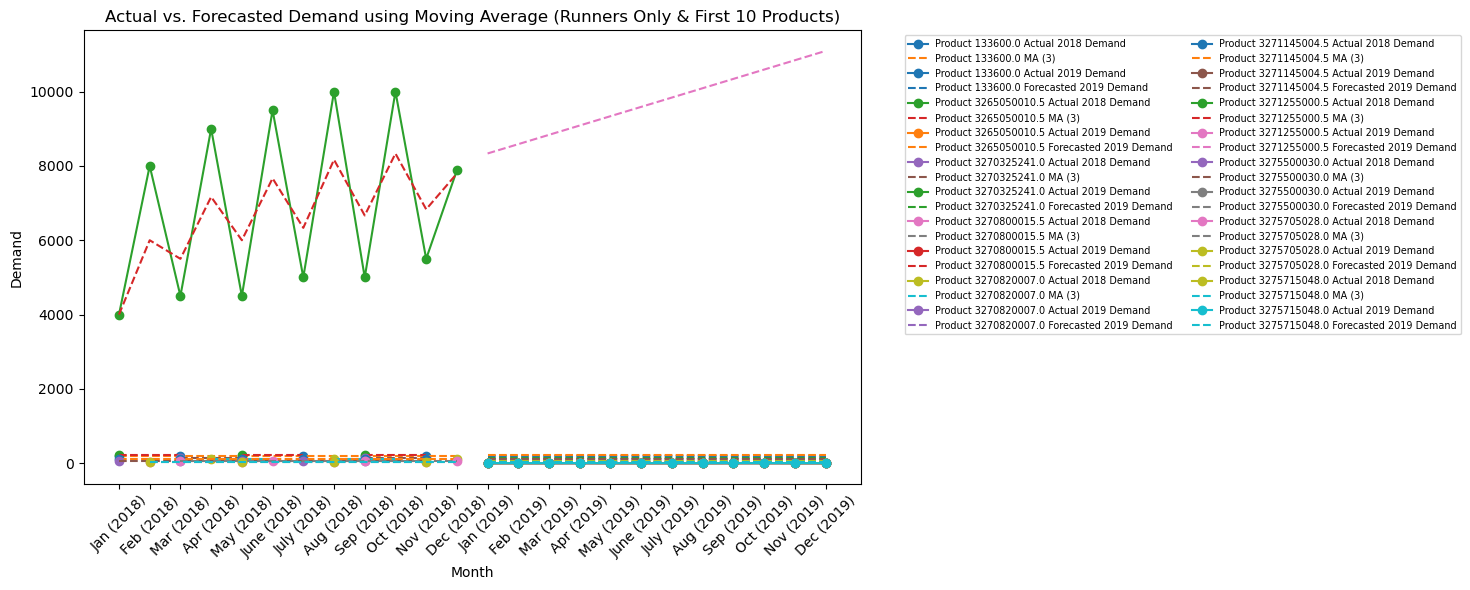

Average MAD for first 10 products: 1062.7373737373737
Average MSE for first 10 products: 9521412.313462907
Average MAPE for first 10 products: 48589.99579124578


In [167]:
from sklearn.linear_model import LinearRegression

# Filter for 'Runners' products
df_runners = df[df['Coeff_Code'] == 'Runner'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_runners.columns.get_loc("Jan (2018)")
end_index_2018 = df_runners.columns.get_loc("Dec (2018)")
start_index_2019 = df_runners.columns.get_loc("Jan (2019)")
end_index_2019 = df_runners.columns.get_loc("Dec (2019)")

# Initialize a plot
plt.figure(figsize=(15, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10)) 

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_runners.iterrows():
    if num_products_processed < 10:
        # Get the color for the current product
        color = colors[num_products_processed]

        # Calculate the moving average for 2018
        train_data = row.iloc[start_index_2018:end_index_2018+1]
        train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean()
        
        # Fit a linear model to the moving averages
        time_index = np.arange(len(train_moving_avg.dropna())).reshape(-1, 1)
        model = LinearRegression().fit(time_index, train_moving_avg.dropna())
        
        # Forecast moving averages for 2019
        forecast_time_index = np.arange(len(time_index), len(time_index) + len(forecast_dates)).reshape(-1, 1)
        forecast_moving_avg = model.predict(forecast_time_index)
        
        # Plot training data and moving average
        plt.plot(df_runners.columns[start_index_2018:end_index_2018+1], train_data, marker='o', label=f'Product {product_id} Actual 2018 Demand')
        plt.plot(df_runners.columns[start_index_2018:end_index_2018+1], train_moving_avg, linestyle='--', label=f'Product {product_id} MA (3)')
        
        # Plot forecast
        forecast_dates = df_runners.columns[start_index_2019:end_index_2019+1]
        plt.plot(forecast_dates, test_data, marker='o', color=color, label=f'Product {product_id} Actual 2019 Demand')
        plt.plot(forecast_dates, forecast_moving_avg, linestyle='--', color=color, label=f'Product {product_id} Forecasted 2019 Demand')

        # Calculate errors
        errors = test_data.values - forecast_moving_avg.flatten()
        
        # Calculate MAD, MSE, MAPE
        mad = np.mean(np.abs(errors))
        mse = np.mean(errors**2)
        mape = np.mean(np.abs(errors / test_data.values)) * 100
        
        # Store the calculated metrics
        mad_list.append(mad)
        mse_list.append(mse)
        mape_list.append(mape)
    
    # Increment the counter
    num_products_processed += 1

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand using Moving Average (Runners Only & First 10 Products)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first 10 products: {average_mad}')
print(f'Average MSE for first 10 products: {average_mse}')
print(f'Average MAPE for first 10 products: {average_mape}')

#### Strangers (First 10 Products)

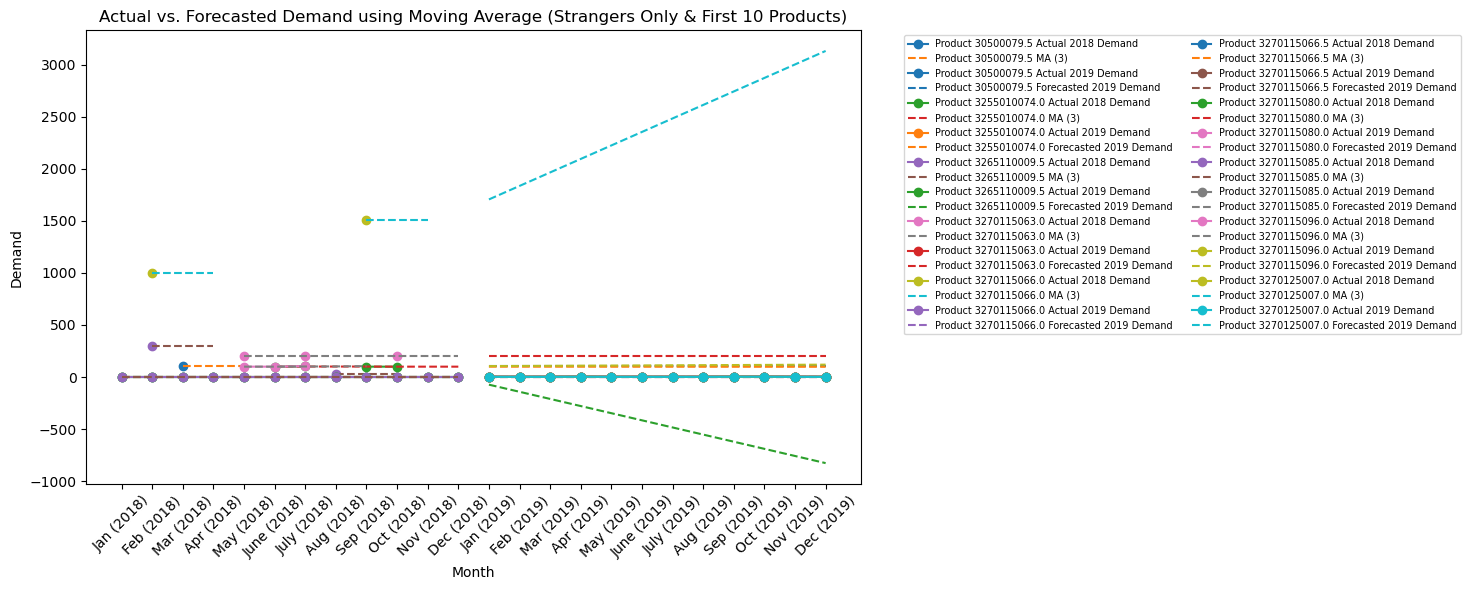

Average MAD for first 10 products: 338.47133333333335
Average MSE for first 10 products: 636909.4725509069
Average MAPE for first 10 products: 15416.426388888887


In [169]:
from sklearn.linear_model import LinearRegression

# Filter for 'Spikers' and 'Stranger' products
df_selected = df[df['Coeff_Code'].isin(['Spiker', 'Stranger'])].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_selected.columns.get_loc("Jan (2018)")
end_index_2018 = df_selected.columns.get_loc("Dec (2018)")
start_index_2019 = df_selected.columns.get_loc("Jan (2019)")
end_index_2019 = df_selected.columns.get_loc("Dec (2019)")

# Initialize a plot
plt.figure(figsize=(15, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10)) 

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_selected.iterrows():
    if num_products_processed < 10:
        # Get the color for the current product
        color = colors[num_products_processed]

        # Calculate the moving average for 2018
        train_data = row.iloc[start_index_2018:end_index_2018+1]
        train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean()
        
        # Fit a linear model to the moving averages
        time_index = np.arange(len(train_moving_avg.dropna())).reshape(-1, 1)
        model = LinearRegression().fit(time_index, train_moving_avg.dropna())
        
        # Forecast moving averages for 2019
        forecast_time_index = np.arange(len(time_index), len(time_index) + len(forecast_dates)).reshape(-1, 1)
        forecast_moving_avg = model.predict(forecast_time_index)
        
        # Plot training data and moving average
        plt.plot(df_selected.columns[start_index_2018:end_index_2018+1], train_data, marker='o', label=f'Product {product_id} Actual 2018 Demand')
        plt.plot(df_selected.columns[start_index_2018:end_index_2018+1], train_moving_avg, linestyle='--', label=f'Product {product_id} MA (3)')
        
        # Plot forecast
        forecast_dates = df_selected.columns[start_index_2019:end_index_2019+1]
        plt.plot(forecast_dates, test_data, marker='o', color=color, label=f'Product {product_id} Actual 2019 Demand')
        plt.plot(forecast_dates, forecast_moving_avg, linestyle='--', color=color, label=f'Product {product_id} Forecasted 2019 Demand')

        # Calculate errors
        errors = test_data.values - forecast_moving_avg.flatten()
        
        # Calculate MAD, MSE, MAPE
        mad = np.mean(np.abs(errors))
        mse = np.mean(errors**2)
        mape = np.mean(np.abs(errors / test_data.values)) * 100
        
        # Store the calculated metrics
        mad_list.append(mad)
        mse_list.append(mse)
        mape_list.append(mape)
    
    # Increment the counter
    num_products_processed += 1

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Actual vs. Forecasted Demand using Moving Average (Strangers Only & First 10 Products)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small', ncol=2)
plt.tight_layout()
plt.show()

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first 10 products: {average_mad}')
print(f'Average MSE for first 10 products: {average_mse}')
print(f'Average MAPE for first 10 products: {average_mape}')

## On a Product Level

### Repeaters

In [13]:
from sklearn.linear_model import LinearRegression

# Filter for 'Repeater' products
df_repeaters = df[df['Coeff_Code'] == 'Repeater'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_repeaters.columns.get_loc("Jan (2018)")
end_index_2018 = df_repeaters.columns.get_loc("Dec (2018)")
start_index_2019 = df_repeaters.columns.get_loc("Jan (2019)")
end_index_2019 = df_repeaters.columns.get_loc("Dec (2019)")

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_repeaters.iterrows():

        # Calculate the moving average for 2018
        train_data = row.iloc[start_index_2018:end_index_2018+1]
        train_data = train_data.dropna()
        test_data = row.iloc[start_index_2019:end_index_2019+1].dropna()
        
        train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean().dropna()
        
        # Fit a linear model to the moving averages
        time_index = np.arange(len(train_moving_avg)).reshape(-1, 1)
        model = LinearRegression().fit(time_index, train_moving_avg)
        
        # Forecast moving averages for 2019
        forecast_time_index = np.arange(len(train_moving_avg), len(train_moving_avg) + len(test_data)).reshape(-1, 1)
        forecast_moving_avg = model.predict(forecast_time_index)
        
        # Calculate errors
        errors = test_data.values - forecast_moving_avg.flatten()
        
        # Calculate MAD, MSE, MAPE
        mad = np.mean(np.abs(errors))
        mse = np.mean(errors**2)
        mape = np.mean(np.abs(errors / test_data.values)) * 100
        
        # Store the calculated metrics
        mad_list.append(mad)
        mse_list.append(mse)
        mape_list.append(mape)
    
        num_products_processed += 1

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first all Repeaters: {average_mad}')
print(f'Average MSE for first all Repeaters: {average_mse}')
print(f'Average MAPE for first all Repeaters: {average_mape}')

Average MAD for first all Repeaters: 0.46429654820065774
Average MSE for first all Repeaters: 0.45855142596030113
Average MAPE for first all Repeaters: 11.440479813940447


### Runners

In [15]:
from sklearn.linear_model import LinearRegression

df_runners = df[df['Coeff_Code'] == 'Runner'].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_runners.columns.get_loc("Jan (2018)")
end_index_2018 = df_runners.columns.get_loc("Dec (2018)")
start_index_2019 = df_runners.columns.get_loc("Jan (2019)")
end_index_2019 = df_runners.columns.get_loc("Dec (2019)")

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_runners.iterrows():

        # Calculate the moving average for 2018
        train_data = row.iloc[start_index_2018:end_index_2018+1]
        train_data = train_data.dropna()
        test_data = row.iloc[start_index_2019:end_index_2019+1].dropna()
        
        train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean().dropna()
        
        # Fit a linear model to the moving averages
        time_index = np.arange(len(train_moving_avg)).reshape(-1, 1)
        model = LinearRegression().fit(time_index, train_moving_avg)
        
        # Forecast moving averages for 2019
        forecast_time_index = np.arange(len(train_moving_avg), len(train_moving_avg) + len(test_data)).reshape(-1, 1)
        forecast_moving_avg = model.predict(forecast_time_index)
        
        # Calculate errors
        errors = test_data.values - forecast_moving_avg.flatten()
        
        # Calculate MAD, MSE, MAPE
        mad = np.mean(np.abs(errors))
        mse = np.mean(errors**2)
        mape = np.mean(np.abs(errors / test_data.values)) * 100
        
        # Store the calculated metrics
        mad_list.append(mad)
        mse_list.append(mse)
        mape_list.append(mape)
    
        num_products_processed += 1

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first all Runners: {average_mad}')
print(f'Average MSE for first all Runners: {average_mse}')
print(f'Average MAPE for first all Runners: {average_mape}')

Average MAD for first all Runners: 23.11100561266065
Average MSE for first all Runners: 13944.712761855608
Average MAPE for first all Runners: 5.228109561235194


### Strangers

In [16]:
from sklearn.linear_model import LinearRegression

df_strangers = df[df['Coeff_Code'].isin(['Spiker', 'Stranger'])].set_index('Part ID').drop(columns=['Coeff_Code'])

# Define the window size for the moving average and locate the indices for 2018 and 2019
window_size = 3

start_index_2018 = df_strangers.columns.get_loc("Jan (2018)")
end_index_2018 = df_strangers.columns.get_loc("Dec (2018)")
start_index_2019 = df_strangers.columns.get_loc("Jan (2019)")
end_index_2019 = df_strangers.columns.get_loc("Dec (2019)")

num_products_processed = 0

# Initialize lists to store metrics for each product
mad_list = []
mse_list = []
mape_list = []

# Process each product
for product_id, row in df_runners.iterrows():

        # Calculate the moving average for 2018
        train_data = row.iloc[start_index_2018:end_index_2018+1]
        train_data = train_data.dropna()
        test_data = row.iloc[start_index_2019:end_index_2019+1].dropna()
        
        train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean().dropna()
        
        # Fit a linear model to the moving averages
        time_index = np.arange(len(train_moving_avg)).reshape(-1, 1)
        model = LinearRegression().fit(time_index, train_moving_avg)
        
        # Forecast moving averages for 2019
        forecast_time_index = np.arange(len(train_moving_avg), len(train_moving_avg) + len(test_data)).reshape(-1, 1)
        forecast_moving_avg = model.predict(forecast_time_index)
        
        # Calculate errors
        errors = test_data.values - forecast_moving_avg.flatten()
        
        # Calculate MAD, MSE, MAPE
        mad = np.mean(np.abs(errors))
        mse = np.mean(errors**2)
        mape = np.mean(np.abs(errors / test_data.values)) * 100
        
        # Store the calculated metrics
        mad_list.append(mad)
        mse_list.append(mse)
        mape_list.append(mape)
    
        num_products_processed += 1

average_mad = np.mean(mad_list)
average_mse = np.mean(mse_list)
average_mape = np.mean(mape_list)

print(f'Average MAD for first all Strangers: {average_mad}')
print(f'Average MSE for first all Strangers: {average_mse}')
print(f'Average MAPE for first all Strangers: {average_mape}')

Average MAD for first all Strangers: 23.11100561266065
Average MSE for first all Strangers: 13944.712761855608
Average MAPE for first all Strangers: 5.228109561235194
